In [1]:
import numpy as np 
import quimb as qu
import quimb.tensor as qtn


# 1. The TEBD algorithm

Here I first used the TEBD algorithm from the example 7(https://quimb.readthedocs.io/en/latest/examples/ex_TEBD_evo.html) for calulating the magnetization of the system, notice that here we calculate <1/2*Z>,<1/2*X>, <1/4*ZZ>, <1/4*XX>,  

In [26]:
#Creation of the state. Here I create a ferromagnetic state, we can think that it's ground state without field with J = -1, 
#then we turn on the field to see the dynamics.
L = 20
zeros = '0' * L
binary = zeros 
psi0 = qtn.MPS_computational_state(binary)

In [27]:
#The field is on here.
H = qtn.ham_1d_ising(L,j=-1,bx=0.5)
 

In [28]:
#The algorithm is applied 
tebd = qtn.TEBD(psi0, H)
tebd.split_opts['cutoff'] = 1e-12

In [29]:
ts = np.linspace(0, 10, 101)

mz_t_j = []  # z-magnetization
mx_t_j = []  # x-magentization
mxx_t_b = [] # xx
mzz_t_b = [] # zz
 

# range of bonds, and sites
js = np.arange(0, L)
bs = np.arange(1, L)


In [30]:
# generate the state at each time in ts
#     and target error 1e-3 for whole evolution
for psit in tebd.at_times(ts, tol=1e-3):
    mz_j = []
    mx_j = []
    mxx_b = []
    mzz_b = []
 
    # there is one more site than bond, so start with mag
    
    mz_j += [psit.magnetization(0)]
    mx_j += [psit.magnetization(0,direction='X')]
    
    for j in range(1, L):
       
        # after which we only need to move it from previous site
        mz_j += [psit.magnetization(j,direction='Z', cur_orthog=j - 1)]
        mx_j += [psit.magnetization(j,direction='X', cur_orthog=j - 1)]  

        # the computation of xx and zz here, I use the correlation function, which is defined as <A>ij -<A>i * <A>j in the source code, so here we add the correlation between
        # neigbour sites and add the product of the magnetization at each site.
        mxx_b += [np.dot(np.real(psit.magnetization(j-1,direction='X')),np.real(psit.magnetization(j,direction='X' )))+np.real(psit.correlation(qu.spin_operator('X'),j-1,j))]  
        mzz_b += [np.dot(np.real(psit.magnetization(j-1,direction='Z')),np.real(psit.magnetization(j,direction='Z' )))+np.real(psit.correlation(qu.spin_operator('Z'),j-1,j))] 
     
  
        
    mz_t_j += [mz_j]
    mx_t_j += [mx_j]
    mxx_t_b += [mxx_b]
    mzz_t_b += [mzz_b]
  
    

t=10, max-bond=24: 100%|#############################################################| 101/101 [01:00<00:00,  1.66it/s]


I know the way for calculating the mxx and mzz is weird but it works! By the way the document of the function 'psit.correlation' is wrong as it says it will return <A(i)> + <A(j)> - <A(ij)>, different from the source code

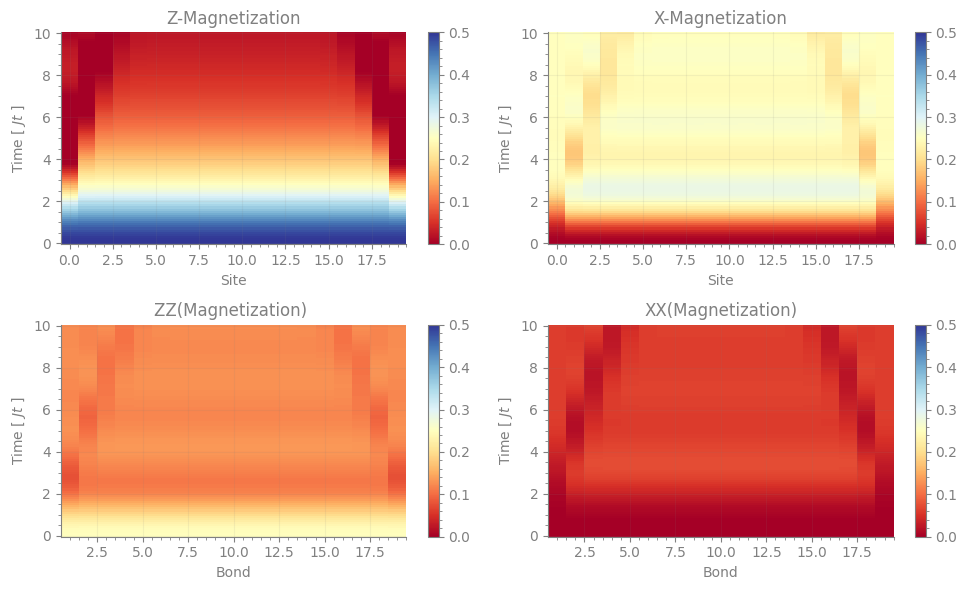

In [31]:
import matplotlib.pyplot as plt
with plt.style.context(qu.NEUTRAL_STYLE):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 6))
    
    # Plot Z-Magnetization
    im1 = ax1.pcolormesh(js, ts, np.real(mz_t_j), vmin=0, vmax=0.5 , cmap='RdYlBu')
    fig.colorbar(im1, ax=ax1)
    ax1.set_title('Z-Magnetization')
    ax1.set_xlabel('Site')
    ax1.set_ylabel('Time [ $Jt$ ]')
    
    # Plot X-Magnetization
    im2 = ax2.pcolormesh(js, ts, np.real(mx_t_j), vmin=0, vmax=0.5 , cmap='RdYlBu')
    fig.colorbar(im2, ax=ax2)
    ax2.set_title('X-Magnetization')
    ax2.set_xlabel('Site')
    ax2.set_ylabel('Time [ $Jt$ ]')
    
    # Plot ZZ
    im3 = ax3.pcolormesh(bs, ts, np.real(mzz_t_b), vmin=0, vmax=0.5  ,cmap='RdYlBu')
    fig.colorbar(im3, ax=ax3)
    ax3.set_title('ZZ(Magnetization) ')
    ax3.set_xlabel('Bond')
    ax3.set_ylabel('Time [ $Jt$ ]')
    
    # Plot XX
    im4 = ax4.pcolormesh(bs, ts, np.real(mxx_t_b), vmin=0, vmax=0.5  , cmap='RdYlBu')
    fig.colorbar(im4, ax=ax4)
    ax4.set_title('XX(Magnetization)')
    ax4.set_xlabel('Bond')
    ax4.set_ylabel('Time [ $Jt$ ]')
    
    
plt.tight_layout()   
plt.savefig("TEBD.png")
plt.show()
   

# 2. The evolution method  

From here I start to use the exact evolution method.I first calulate the same thing, that is, the expectation of the spin operators to compare with the TEBD method and check my method

## 2.1 Verify and compare

In [33]:
# Creation of the initial state as well
n = 20
H = qu.ham_ising(n, jz=-1, bx=0.5,sparse = True)
s = '0' * n
st = qu.computational_state(s)
psi0 = qu.qu(st)

dims = [2] * n  # Define dims here



#By using qu.spin_operator() we are calculating the magnetization,uncomment the pauli ones we will calculate what we want. 
Z = qu.spin_operator('Z')
X = qu.spin_operator('X')
#Z =qu.pauli('Z')
#X = qu.pauli('X')
ZZ = Z & Z
XX = X & X

operators = [ZZ,XX]  

# Create a list of lists of operators, not considering periodic boundary condition here
operators_i1 = [[qu.ikron(op, dims, [i, i+1],sparse = True) for op in operators] for i in range(0, n-1)]
 
operators = [Z, X]  

# Create a list of lists of operators
operators_i2 = [[qu.ikron(op, dims, [i],sparse = True) for op in operators] for i in range(n)]
 
def compute(t, pt):
    """Perform computation at time ``t`` with state ``pt``.
    """
    sz_expectations = []
    sx_expectations = []
    szz_expectations = []
    sxx_expectations = []
    
    for operator_list in operators_i2:
        site_sz = qu.expec(pt, operator_list[0])  # Z expectation
        site_sx = qu.expec(pt, operator_list[1])  # X expectation
        sz_expectations.append(site_sz)
        sx_expectations.append(site_sx)
        
    for operator_list in operators_i1:
        site_szz = qu.expec(pt, operator_list[0])  # ZZ expectation
        site_sxx = qu.expec(pt, operator_list[1])  # XX expectation
        szz_expectations.append(site_szz)
        sxx_expectations.append(site_sxx)
        
    return t, sz_expectations, sx_expectations, szz_expectations, sxx_expectations


evo = qu.Evolution(psi0, H, progbar=True, compute=compute)
evo.update_to(10)

100%|#################################################################################| 100/100 [01:16<00:00,  1.31%/s]


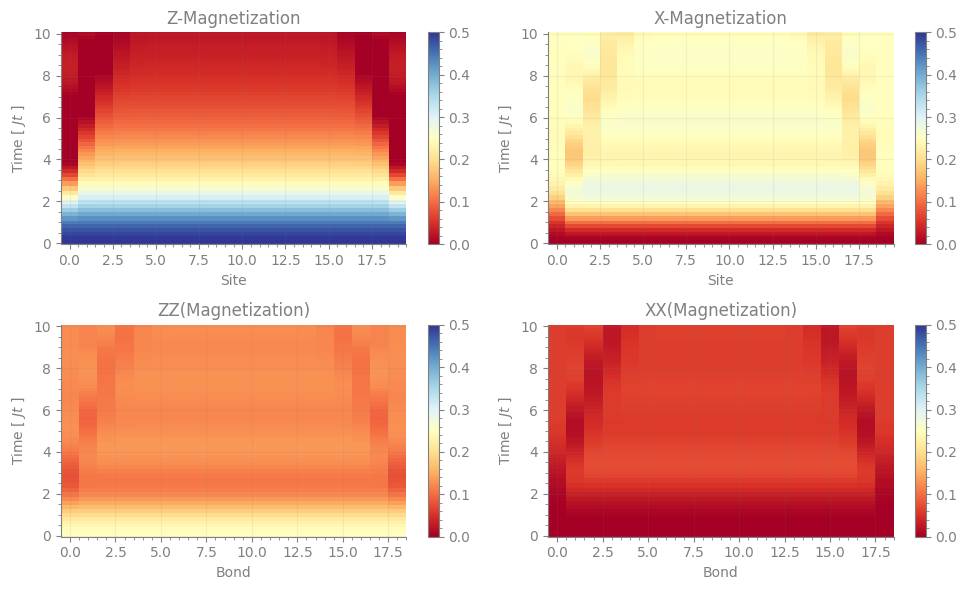

In [34]:
import matplotlib.pyplot as plt
ts,sz_expectations,sx_expectations,szz_expectations,sxx_expectations= zip(*evo.results)
 
# sites and bonds
js = np.arange(0, n)
bs = np.arange(0,n-1)

sz = np.array(sz_expectations)  # Convert to a NumPy array
sz = sz.reshape(len(ts), n)  # Reshape sz to (number of timesteps, number of sites)
sx = np.array(sx_expectations)  # same
sx = sx.reshape(len(ts), n)  
sxx = np.array(sxx_expectations)  #same but now the shape will be (number of timesteps, number of bonds)
sxx = sxx.reshape(len(ts), n-1)  
szz = np.array(szz_expectations)  # same
szz = szz.reshape(len(ts), n-1)  

with plt.style.context(qu.NEUTRAL_STYLE):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 6))
    
    # Plot Z-Magnetization
    im1 = ax1.pcolormesh(js, ts, np.real(sz), vmin=0, vmax=0.5 , cmap='RdYlBu')
    fig.colorbar(im1, ax=ax1)
    ax1.set_title('Z-Magnetization')
    ax1.set_xlabel('Site')
    ax1.set_ylabel('Time [ $Jt$ ]')
    
    # Plot X-Magnetization
    im2 = ax2.pcolormesh(js, ts, np.real(sx), vmin=0, vmax=0.5 , cmap='RdYlBu')
    fig.colorbar(im2, ax=ax2)
    ax2.set_title('X-Magnetization')
    ax2.set_xlabel('Site')
    ax2.set_ylabel('Time [ $Jt$ ]')
    
    im3 = ax3.pcolormesh(bs, ts, np.real(szz), vmin=0, vmax=0.5  ,cmap='RdYlBu')
    fig.colorbar(im3, ax=ax3)
    ax3.set_title('ZZ(Magnetization)')
    ax3.set_xlabel('Bond')
    ax3.set_ylabel('Time [ $Jt$ ]')
    
    im4 = ax4.pcolormesh(bs, ts, np.real(sxx), vmin=0, vmax=0.5  , cmap='RdYlBu')
    fig.colorbar(im4, ax=ax4)
    ax4.set_title('XX(Magnetization)')
    ax4.set_xlabel('Bond')
    ax4.set_ylabel('Time [ $Jt$ ]')
    
 
    
plt.tight_layout()  # Ensures subplots do not overlap
plt.savefig("verify.png")
plt.show()

You can both compare the figures and print the data from the 2 methods and they are bascially the same.Thus I think the general way for the time evolution method is correct, next we can calculate the expecation of X,Z,XX,ZZ,I will try to put different protocols here.

## 2.2 The big quench(start as |0>, bx from 0 to 0.5)

In [11]:
# Creation of the initial state as well
n =20
H = qu.ham_ising(n, jz = -1, bx = 0.5,sparse = True )
s = '0' * n
st = qu.computational_state(s)
psi0 = qu.qu(st)
 

dims = [2] * n  # Define dims here

Z =qu.pauli('Z')
X = qu.pauli('X')
ZZ = Z & Z
XX = X & X

operators = [ZZ,XX]  

# Create a list of lists of operators, not considering periodic boundary condition here
operators_i1 = [[qu.ikron(op, dims, [i, i+1],sparse = True ) for op in operators] for i in range(0, n-1)]
 
operators = [Z, X]  

# Create a list of lists of operators
operators_i2 = [[qu.ikron(op, dims, [i],sparse = True ) for op in operators] for i in range(n)]
 
def compute(t, pt):
    """Perform computation at time ``t`` with state ``pt``.
    """
    sz_expectations = []
    sx_expectations = []
    szz_expectations = []
    sxx_expectations = []
    
    for operator_list in operators_i2:
        site_sz = qu.expec(pt, operator_list[0])  # Z expectation
        site_sx = qu.expec(pt, operator_list[1])  # X expectation
        sz_expectations.append(site_sz)
        sx_expectations.append(site_sx)
        
    for operator_list in operators_i1:
        site_szz = qu.expec(pt, operator_list[0])  # ZZ expectation
        site_sxx = qu.expec(pt, operator_list[1])  # XX expectation
        szz_expectations.append(site_szz)
        sxx_expectations.append(site_sxx)
        
    return t, sz_expectations, sx_expectations, szz_expectations, sxx_expectations


evo = qu.Evolution(psi0, H, progbar=True, compute=compute)
evo.update_to(10)

100%|#################################################################################| 100/100 [01:16<00:00,  1.30%/s]


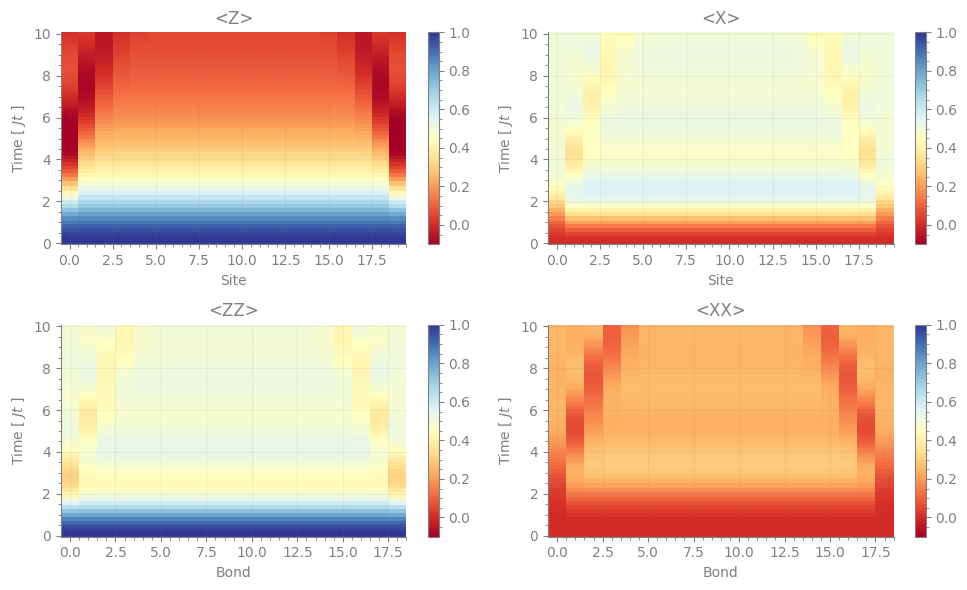

In [12]:
import matplotlib.pyplot as plt
ts,sz_expectations,sx_expectations,szz_expectations,sxx_expectations= zip(*evo.results)
 
# sites and bonds
js = np.arange(0, n)
bs = np.arange(0,n-1)

sz = np.array(sz_expectations)  # Convert to a NumPy array
sz = sz.reshape(len(ts), n)  # Reshape sz to (number of timesteps, number of sites)
sx = np.array(sx_expectations)  # same
sx = sx.reshape(len(ts), n)  
sxx = np.array(sxx_expectations)  #same but now the shape will be (number of timesteps, number of bonds)
sxx = sxx.reshape(len(ts), n-1)  
szz = np.array(szz_expectations)  # same
szz = szz.reshape(len(ts), n-1)  

with plt.style.context(qu.NEUTRAL_STYLE):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 6))
    
    # Plot Z-Magnetization
    im1 = ax1.pcolormesh(js, ts, np.real(sz), vmax=0,vmin=1, cmap='RdYlBu')
    fig.colorbar(im1, ax=ax1)
    ax1.set_title('<Z>')
    ax1.set_xlabel('Site')
    ax1.set_ylabel('Time [ $Jt$ ]')
    
    # Plot X-Magnetization
    im2 = ax2.pcolormesh(js, ts, np.real(sx),vmax=0,vmin=1,  cmap='RdYlBu')
    fig.colorbar(im2, ax=ax2)
    ax2.set_title('<X>')
    ax2.set_xlabel('Site')
    ax2.set_ylabel('Time [ $Jt$ ]')
    
    im3 = ax3.pcolormesh(bs, ts, np.real(szz),vmax=0,vmin=1  ,cmap='RdYlBu')
    fig.colorbar(im3, ax=ax3)
    ax3.set_title('<ZZ>')
    ax3.set_xlabel('Bond')
    ax3.set_ylabel('Time [ $Jt$ ]')
    
    im4 = ax4.pcolormesh(bs, ts, np.real(sxx) ,vmax=0,vmin=1 , cmap='RdYlBu')
    fig.colorbar(im4, ax=ax4)
    ax4.set_title('<XX>')
    ax4.set_xlabel('Bond')
    ax4.set_ylabel('Time [ $Jt$ ]')
    
 
    
plt.tight_layout()  # Ensures subplots do not overlap
 
plt.show()

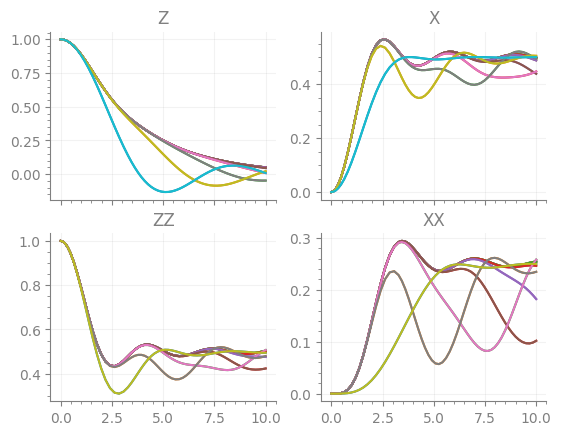

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

with plt.style.context(qu.NEUTRAL_STYLE):
    fig, axs = plt.subplots(2, 2, sharex=True)
    axs[0,0].plot(ts, np.real(sz), '-');
    axs[0,0].set_title("Z")
    axs[0,1].plot(ts, np.real(sx), '-');
    axs[0,1].set_title("X")
    axs[1,0].plot(ts, np.real(szz), '-');
    axs[1,0].set_title("ZZ")
    axs[1,1].plot(ts, np.real(sxx), '-');
    axs[1,1].set_title("XX")

## 2.3 The phase study of AFM->PM phase transition


This is according to the phase diagram of https://doi.org/10.1103/PhysRevB.92.104306, which includes a phase diagram like this:


<img src = "phase diagram.png" style = "width: 200px" >

The h axis is the longitudinal field, which is 0 here in the computation

In [44]:
n = 20
H_i = qu.gen.operators.ham_ising(n,jz = 1, bx= 0, sparse = True,cyclic=True)
#H_i = qu.gen.operators.ham_ising(n,jz = 1, bx= 0, sparse = True ) 
psi0 = qu.groundstate(H_i)

In [45]:
H = qu.ham_ising(n, jz=1, bx=2,sparse = True,cyclic=True)# now we expect a PM phase 
#H = qu.ham_ising(n, jz=1, bx=2,sparse = True )
dims = [2] * n  # Define dims here

Z =qu.pauli('Z')
X = qu.pauli('X')
ZZ = Z & Z
XX = X & X

operators = [ZZ,XX]  

# Create a list of lists of operators, not considering periodic boundary condition here
operators_i1 = [[qu.ikron(op, dims, [i, i+1],sparse = True ) for op in operators] for i in range(0, n-1)]
 
operators = [Z, X]  

# Create a list of lists of operators
operators_i2 = [[qu.ikron(op, dims, [i],sparse = True ) for op in operators] for i in range(n)]
 
def compute(t, pt):
    """Perform computation at time ``t`` with state ``pt``.
    """
    sz_expectations = []
    sx_expectations = []
    szz_expectations = []
    sxx_expectations = []
    
    for operator_list in operators_i2:
        site_sz = qu.expec(pt, operator_list[0])  # Z expectation
        site_sx = qu.expec(pt, operator_list[1])  # X expectation
        sz_expectations.append(site_sz)
        sx_expectations.append(site_sx)
        
    for operator_list in operators_i1:
        site_szz = qu.expec(pt, operator_list[0])  # ZZ expectation
        site_sxx = qu.expec(pt, operator_list[1])  # XX expectation
        szz_expectations.append(site_szz)
        sxx_expectations.append(site_sxx)
        
    return t, sz_expectations, sx_expectations, szz_expectations, sxx_expectations


evo = qu.Evolution(psi0, H, progbar=True, compute=compute)
evo.update_to(20)

100%|#################################################################################| 100/100 [06:19<00:00,  3.80s/%]


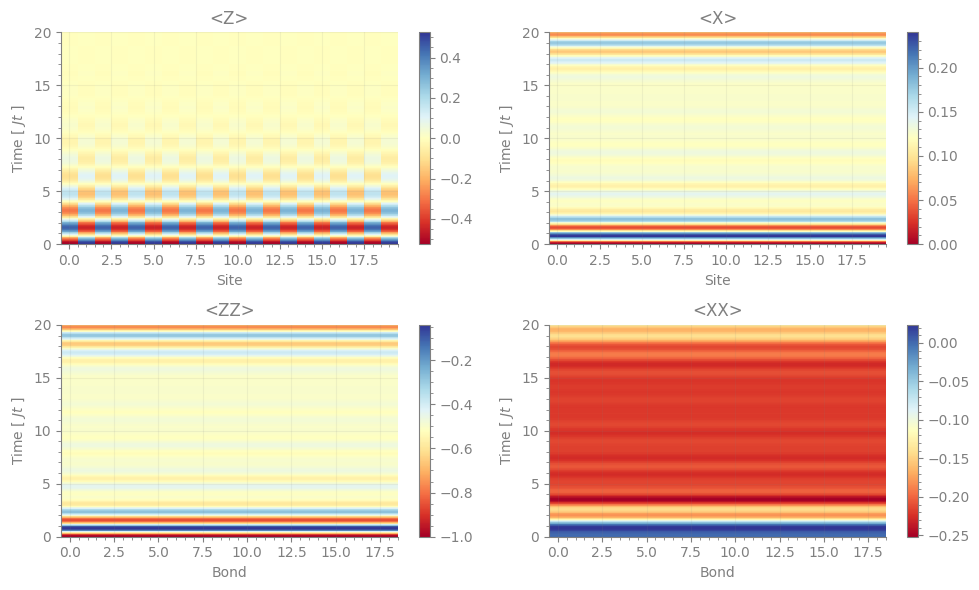

In [46]:
import matplotlib.pyplot as plt
ts,sz_expectations,sx_expectations,szz_expectations,sxx_expectations= zip(*evo.results)
 
# sites and bonds
js = np.arange(0, n)
bs = np.arange(0,n-1)

sz = np.array(sz_expectations)  # Convert to a NumPy array
sz = sz.reshape(len(ts), n)  # Reshape sz to (number of timesteps, number of sites)
sx = np.array(sx_expectations)  # same
sx = sx.reshape(len(ts), n)  
sxx = np.array(sxx_expectations)  #same but now the shape will be (number of timesteps, number of bonds)
sxx = sxx.reshape(len(ts), n-1)  
szz = np.array(szz_expectations)  # same
szz = szz.reshape(len(ts), n-1)  

with plt.style.context(qu.NEUTRAL_STYLE):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 6))
    
    # Plot Z-Magnetization
    im1 = ax1.pcolormesh(js, ts, np.real(sz) , cmap='RdYlBu')
    fig.colorbar(im1, ax=ax1)
    ax1.set_title('<Z>')
    ax1.set_xlabel('Site')
    ax1.set_ylabel('Time [ $Jt$ ]')
    
    # Plot X-Magnetization
    im2 = ax2.pcolormesh(js, ts, np.real(sx),  cmap='RdYlBu')
    fig.colorbar(im2, ax=ax2)
    ax2.set_title('<X>')
    ax2.set_xlabel('Site')
    ax2.set_ylabel('Time [ $Jt$ ]')
    
    im3 = ax3.pcolormesh(bs, ts, np.real(szz) ,cmap='RdYlBu')
    fig.colorbar(im3, ax=ax3)
    ax3.set_title('<ZZ>')
    ax3.set_xlabel('Bond')
    ax3.set_ylabel('Time [ $Jt$ ]')
    
    im4 = ax4.pcolormesh(bs, ts, np.real(sxx)  , cmap='RdYlBu')
    fig.colorbar(im4, ax=ax4)
    ax4.set_title('<XX>')
    ax4.set_xlabel('Bond')
    ax4.set_ylabel('Time [ $Jt$ ]')
    
 
    
plt.tight_layout()  # Ensures subplots do not overlap
plt.savefig("quench_p.png")
plt.show()

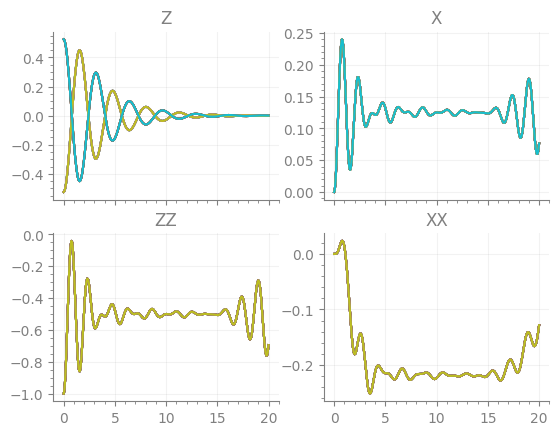

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt

with plt.style.context(qu.NEUTRAL_STYLE):
    fig, axs = plt.subplots(2, 2, sharex=True)
    axs[0,0].plot(ts, np.real(sz), '-');
    axs[0,0].set_title("Z")
    axs[0,1].plot(ts, np.real(sx), '-');
    axs[0,1].set_title("X")
    axs[1,0].plot(ts, np.real(szz), '-');
    axs[1,0].set_title("ZZ")
    axs[1,1].plot(ts, np.real(sxx), '-');
    axs[1,1].set_title("XX")
plt.savefig("quench_line_p.png")

## 2.4 Evolution of spin-flipped state

For this one I add 3 flipped spins in a ferromagnetic ground state and try to see the evolution, for the rest of the part I use exactly the same configuration as the 2.2 case, so we can see the difference.

In [18]:
# Creation of the initial state as well
n =20
H = qu.ham_ising(n, jz = -1, bx = 0.5,sparse = True )
zeros = '0' * ((L - 3) // 4)
flip = zeros + '1' + zeros + '1' + zeros+ '1' + zeros +'0'
st = qu.computational_state(flip)
psi0 = qu.qu(st)

dims = [2] * n  # Define dims here

Z =qu.pauli('Z')
X = qu.pauli('X')
ZZ = Z & Z
XX = X & X

operators = [ZZ,XX]  

# Create a list of lists of operators, not considering periodic boundary condition here
operators_i1 = [[qu.ikron(op, dims, [i, i+1],sparse = True ) for op in operators] for i in range(0, n-1)]
 
operators = [Z, X]  

# Create a list of lists of operators
operators_i2 = [[qu.ikron(op, dims, [i],sparse = True ) for op in operators] for i in range(n)]
 
def compute(t, pt):
    """Perform computation at time ``t`` with state ``pt``.
    """
    sz_expectations = []
    sx_expectations = []
    szz_expectations = []
    sxx_expectations = []
    
    for operator_list in operators_i2:
        site_sz = qu.expec(pt, operator_list[0])  # Z expectation
        site_sx = qu.expec(pt, operator_list[1])  # X expectation
        sz_expectations.append(site_sz)
        sx_expectations.append(site_sx)
        
    for operator_list in operators_i1:
        site_szz = qu.expec(pt, operator_list[0])  # ZZ expectation
        site_sxx = qu.expec(pt, operator_list[1])  # XX expectation
        szz_expectations.append(site_szz)
        sxx_expectations.append(site_sxx)
        
    return t, sz_expectations, sx_expectations, szz_expectations, sxx_expectations


evo = qu.Evolution(psi0, H, progbar=True, compute=compute)
evo.update_to(20)

100%|#################################################################################| 100/100 [01:41<00:00,  1.01s/%]


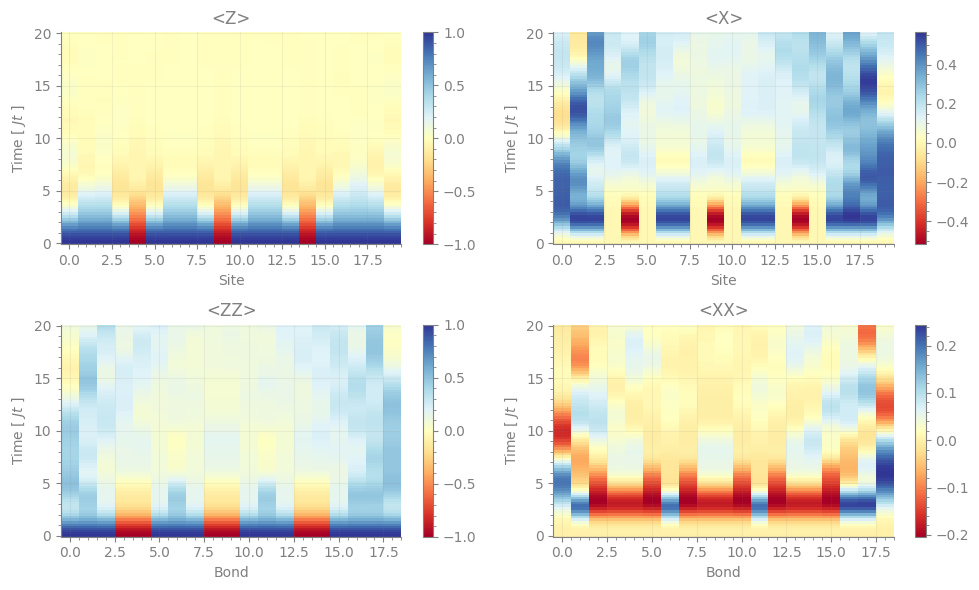

In [19]:
import matplotlib.pyplot as plt
ts,sz_expectations,sx_expectations,szz_expectations,sxx_expectations= zip(*evo.results)
 
# sites and bonds
js = np.arange(0, n)
bs = np.arange(0,n-1)

sz = np.array(sz_expectations)  # Convert to a NumPy array
sz = sz.reshape(len(ts), n)  # Reshape sz to (number of timesteps, number of sites)
sx = np.array(sx_expectations)  # same
sx = sx.reshape(len(ts), n)  
sxx = np.array(sxx_expectations)  #same but now the shape will be (number of timesteps, number of bonds)
sxx = sxx.reshape(len(ts), n-1)  
szz = np.array(szz_expectations)  # same
szz = szz.reshape(len(ts), n-1)  

with plt.style.context(qu.NEUTRAL_STYLE):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 6))
    
    # Plot Z-Magnetization
    im1 = ax1.pcolormesh(js, ts, np.real(sz) , cmap='RdYlBu')
    fig.colorbar(im1, ax=ax1)
    ax1.set_title('<Z>')
    ax1.set_xlabel('Site')
    ax1.set_ylabel('Time [ $Jt$ ]')
    
    # Plot X-Magnetization
    im2 = ax2.pcolormesh(js, ts, np.real(sx),  cmap='RdYlBu')
    fig.colorbar(im2, ax=ax2)
    ax2.set_title('<X>')
    ax2.set_xlabel('Site')
    ax2.set_ylabel('Time [ $Jt$ ]')
    
    im3 = ax3.pcolormesh(bs, ts, np.real(szz) ,cmap='RdYlBu')
    fig.colorbar(im3, ax=ax3)
    ax3.set_title('<ZZ>')
    ax3.set_xlabel('Bond')
    ax3.set_ylabel('Time [ $Jt$ ]')
    
    im4 = ax4.pcolormesh(bs, ts, np.real(sxx)  , cmap='RdYlBu')
    fig.colorbar(im4, ax=ax4)
    ax4.set_title('<XX>')
    ax4.set_xlabel('Bond')
    ax4.set_ylabel('Time [ $Jt$ ]')
    
 
    
plt.tight_layout()  # Ensures subplots do not overlap
 
plt.show()

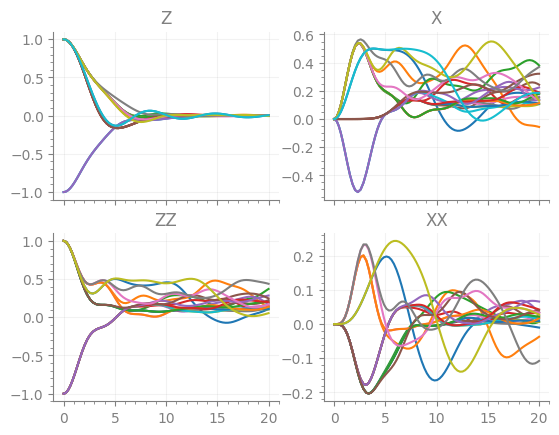

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

with plt.style.context(qu.NEUTRAL_STYLE):
    fig, axs = plt.subplots(2, 2, sharex=True)
    axs[0,0].plot(ts, np.real(sz), '-');
    axs[0,0].set_title("Z")
    axs[0,1].plot(ts, np.real(sx), '-');
    axs[0,1].set_title("X")
    axs[1,0].plot(ts, np.real(szz), '-');
    axs[1,0].set_title("ZZ")
    axs[1,1].plot(ts, np.real(sxx), '-');
    axs[1,1].set_title("XX")

This is for now, I will try to find more papers with interesting phase diagram in them for simulation